# REMEMBER to start the spark cluster with the little star icon before executing the notebook


# Hands-on Day 1

- course [slides](https://github.com/leggerf/MLCourse-1920/blob/master/Slides/Day1/ML-day1.pdf)

# You'll learn

- familiarize with jupyter notebooks, numpy and pandas

## Input data
- efficient data format: convert CSV to Parquet
- create input vector with features for MLLib. Format of the input depends on chosen ML library

## Visualization
- explore dataset, plot features
- correlation matrix


# Dataset description

The dataset used in this example is described [here](https://archive.ics.uci.edu/ml/datasets/HIGGS). It is a binary classification problem where the goal is to train a classifier able to distinguish between a signal process, the production of new theoretical Higgs bosons, and a background process with identical decay products but distinct kinematic features.

Each row of this dataset contains 28 features plus the label:

- 21 low-level features which represent the basic measure made by the particle detector
 -        Momentum of the observed paricles
 -        Missing transverse momentum
 -        Jets and b-tagging information
- 7 high-level features computed from the low-level features that encode the knowledge of the different intermediate states of the two processes (reconstructed invariant masses)

## Prepare the execution environment

Your code will run on a single dedicated server with 24 cores (hyperthreading enabled) and 192 GB of RAM. 
All the services needed for this tutorial are deployed as Kubernetes applications on this server. These include:
* JupytherHub
* Jupyter single-user servers
* the HDFS file-system
* Spark Clusters on demand 

In [3]:
#!pip install pandas
#!pip install seaborn

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Check out these custom functions
from custom_functions import *

## Read in from Minio


In [6]:
#!pip install liboidcagent requests xmltodict pandas boto3

In [7]:
!eval `oidc-keychain` > /dev/null && oidc-token dodas --time=3600 > /tmp/token
with open('/tmp/token') as f:
    token = f.readlines()[0].split("\n")[0]

In [8]:
import requests
import xmltodict
r = requests.post("https://minio.cloud.infn.it",
                  data={
                      'Action':
                      "AssumeRoleWithWebIdentity",
                      'Version': "2011-06-15",
                      'WebIdentityToken': token,
                      'DurationSeconds': 9000
                  },
                  verify=True)

tree = xmltodict.parse(r.content)

credentials = dict(tree['AssumeRoleWithWebIdentityResponse']
                    ['AssumeRoleWithWebIdentityResult']['Credentials'])

In [12]:
from pyspark import SparkConf, SparkContext
conf = (SparkConf()
         .setMaster("k8s://https://kubernetes:443")
         .setAppName("MyApp")
         .set("spark.executor.memory", "1g")
         .set("spark.executor.instances", "2")
         .set("spark.kubernetes.container.image", "dodasts/spark:v3.0.1")
# configure S3 access  
         .set("spark.hadoop.fs.s3a.endpoint", "https://minio.cloud.infn.it")
         .set("spark.hadoop.fs.s3a.aws.credentials.provider","org.apache.hadoop.fs.s3a.TemporaryAWSCredentialsProvider")
         .set("spark.hadoop.fs.s3a.access.key", credentials["AccessKeyId"])
         .set("spark.hadoop.fs.s3a.secret.key", credentials["SecretAccessKey"]) 
         .set("spark.hadoop.fs.s3a.session.token", credentials["SessionToken"])
         .set("spark.hadoop.fs.s3a.path.style.access","true")
         .set("spark.hadoop.fs.s3a.fast.upload", "true")
         .set("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
         .set("spark.hadoop.fs.s3a.committer.name", "directory")
       )

sc = SparkContext(conf = conf)
sc

,Unnamed: 0,label,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet1_pt,jet1_eta,jet1_phi,...,je4_eta,jet4_phi,jet4_b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,...,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,1,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,2,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,3,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
4,4,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,999994,0.0,1.289299,-1.108431,0.970869,0.418467,-0.236384,1.439424,1.415013,0.384343,...,-0.196174,-0.649514,3.101961,3.715858,2.295703,0.990350,0.826123,0.602524,1.549889,1.489945
999995,999995,1.0,0.514256,0.441154,0.641281,0.376795,0.840085,0.812464,-0.038644,-0.329241,...,0.032852,1.471465,0.000000,0.813464,0.723074,0.984661,0.734838,0.226974,0.817835,0.750583
999996,999996,1.0,1.586689,0.798600,-1.038389,0.186234,-1.465364,1.328488,0.356457,0.846692,...,0.155277,-0.170067,3.101961,2.318721,1.348919,0.997061,1.345282,0.984395,1.167846,1.042671
999997,999997,0.0,1.833751,0.194740,1.489664,0.453500,0.077691,1.112570,1.208055,0.155386,...,0.112803,0.599699,0.000000,1.033291,0.878243,1.207249,0.980557,1.977671,1.186537,1.025073


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession(sc)
# read the CSV with some options         
df = spark.read.options(header='True',inferSchema='True').csv("s3a://legger/MLCourseInput/Higgs1M.csv")
df.printSchema()

## Or read in local csv files

In [3]:
inputFile = 'Higgs100k.csv'

#into panda DF
%time dataset = pd.read_csv(inputFile)

CPU times: user 3.88 s, sys: 448 ms, total: 4.32 s
Wall time: 4.4 s


In [ ]:
#then into spark dataframe...remember to start spark with the little icon

%time df = spark.createDataFrame(dataset)

In [5]:
#In how many partitions is the dataframe distributed?
print("Number of partitions: {}".format(df.rdd.getNumPartitions()))
print("Partitioner: {}".format(df.rdd.partitioner))

Number of partitions: 2
Partitioner: None


# Now let's have a look at the input data

In [10]:
%time total_events = df.count()

print('There are '+str(total_events)+' events')

CPU times: user 720 ms, sys: 0 ns, total: 720 ms
Wall time: 1.27 s
There are Unnamed: 0                  999999
label                       999999
lepton_pT                   999999
lepton_eta                  999999
lepton_phi                  999999
missing_energy_magnitude    999999
missing_energy_phi          999999
jet1_pt                     999999
jet1_eta                    999999
jet1_phi                    999999
jet1_b-tag                  999999
jet2_pt                     999999
jet2_eta                    999999
jet2_phi                    999999
jet2_b-tag                  999999
jet3_pt                     999999
jet3_eta                    999999
jet3_phi                    999999
jet3_b-tag                  999999
jet4_pt                     999999
je4_eta                     999999
jet4_phi                    999999
jet4_b-tag                  999999
m_jj                        999999
m_jjj                       999999
m_lv                        999999
m_jlv        

In [11]:
df.printSchema()

AttributeError: 'DataFrame' object has no attribute 'printSchema'

# Exercise 3

- Create a function that makes a plot of any of the above variable for signal versus background (using the label variable to discriminate)
  - see an example of the plot in the hands-on [slides](https://github.com/leggerf/MLCourse-1920/blob/master/Slides/Day1/ML-handson-day1.pdf)
  - the function should take as input the dataframe *df* and the variable name. For example `plotSignalvsBg(df, 'm_bb')`
  - to develop the code, use the 100k dataset, so that debugging goes quicker
- try to plot a few input variables and try to understand which ones are more promising to distinguish signal from background  

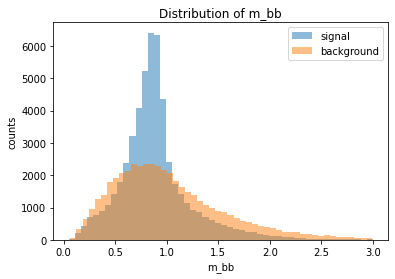

In [8]:
#plot invariant mass distribution 
plotSignalvsBg(df, 'm_bb')

# Exercise 4 - Bonus

#### Create the input feature vector

- Libraries for ML tipically take as inputs data in a very specific format. Documentation on how to do data preprocessing in Spark: https://spark.apache.org/docs/latest/ml-features.html
- Try to add to the dataframe df a new column, called 'features' which is a vector column with all the variables above except for 'label'
   - features = [lepton_pT, lepton_eta, lepton_phi, ...]
   - Hint: look at the VectorAssembler transformer

In [9]:
#create input vector for ML (features)
feature = df.columns
feature.remove('label')

#VectorAssembler is a transformer that combines a given list of columns into a single vector column
assembler = VectorAssembler(inputCols=feature, outputCol='features')
df = assembler.transform(df)

#take a look at how there is now a features column
display(df)
df.select('features').take(1)

#note also that features are already standardised between -1 and 1, so rescaling won't be needed

DataFrame[label: double, lepton_pT: double, lepton_eta: double, lepton_phi: double, missing_energy_magnitude: double, missing_energy_phi: double, jet1_pt: double, jet1_eta: double, jet1_phi: double, jet1_b-tag: double, jet2_pt: double, jet2_eta: double, jet2_phi: double, jet2_b-tag: double, jet3_pt: double, jet3_eta: double, jet3_phi: double, jet3_b-tag: double, jet4_pt: double, je4_eta: double, jet4_phi: double, jet4_b-tag: double, m_jj: double, m_jjj: double, m_lv: double, m_jlv: double, m_bb: double, m_wbb: double, m_wwbb: double, features: vector]

[Row(features=DenseVector([0.8693, -0.6351, 0.2257, 0.3275, -0.69, 0.7542, -0.2486, -1.0921, 0.0, 1.375, -0.6537, 0.9303, 1.1074, 1.1389, -1.5782, -1.047, 0.0, 0.6579, -0.0105, -0.0458, 3.102, 1.3538, 0.9796, 0.9781, 0.92, 0.7217, 0.9888, 0.8767]))]

Print (or draw) the correlation matrix (a table showing correlation coefficients between variables)

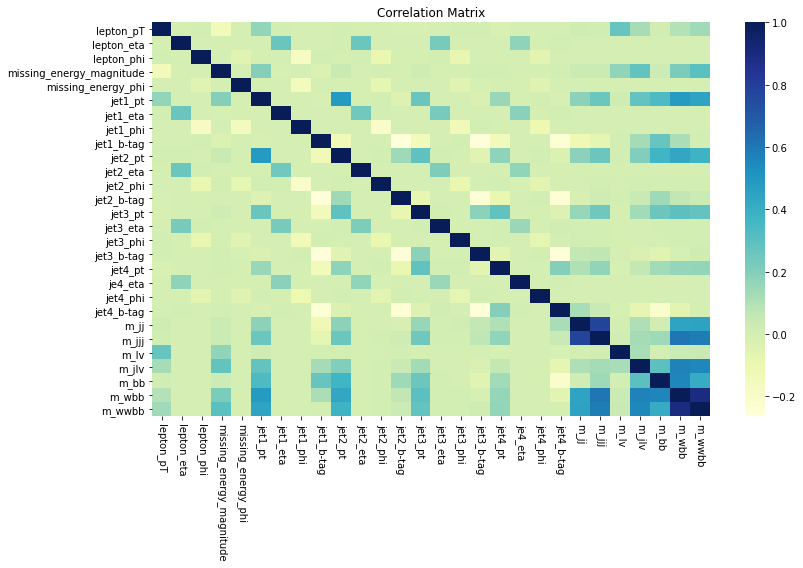

In [10]:
plotCorrelation(df, feature)

In [11]:
#when you're done, stop spark, this will release the resources you're using
#spark.stop()